In [48]:
from pytorch_model_summary import summary as summarys
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from collections import OrderedDict
from flwr.common import Metrics
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np
import flwr as fl
import torch



DEVICE = torch.device("cpu")
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.3.0+cu118 and Flower 1.8.0


In [49]:
# Data
TRAIN_BATCH_SIZE = VAL_BATCH_SIZE = 32
VAL_SPLIT_RATIO = 0.2
STABILITY_THRESHOLD = 104

# Model
INPUT_SIZE = 4
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1

# Training
EPOCHS = 50
NUM_CLIENTS = 3

In [81]:
class StabilityClassifier(nn.Module):
    def __init__(self, input_size = INPUT_SIZE, hidden_size = HIDDEN_SIZE, output_size = OUTPUT_SIZE):
        super(StabilityClassifier, self).__init__()
        
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.act3 = nn.ReLU()
        self.drop1 = nn.Dropout()
        self.drop2 = nn.Dropout()
        self.drop3 = nn.Dropout()
        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h1 = nn.Linear(hidden_size, hidden_size)
        self.h2h2 = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.drop1(self.act1(self.i2h(x)))
        x = self.drop2(self.act2(self.h2h1(x)))
        x = self.drop3(self.act3(self.h2h2(x)))
        out = self.h2o(x)
        
        return torch.sigmoid(out)
    
print(summarys(StabilityClassifier(), torch.zeros((1, 1, 4)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1           [1, 1, 4]             256             256
            ReLU-2          [1, 1, 64]               0               0
         Dropout-3          [1, 1, 64]               0               0
          Linear-4          [1, 1, 64]           4,160           4,160
            ReLU-5          [1, 1, 64]               0               0
         Dropout-6          [1, 1, 64]               0               0
          Linear-7          [1, 1, 64]           4,160           4,160
            ReLU-8          [1, 1, 64]               0               0
         Dropout-9          [1, 1, 64]               0               0
         Linear-10          [1, 1, 64]              65              65
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
-----------------------------------------------------------------------


In [51]:
def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            inputs, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
            optimizer.zero_grad()
            outputs = torch.squeeze(net(inputs))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += ((outputs.data.round()) == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        # print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}, correct {correct}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.BCELoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            inputs, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
            outputs = torch.squeeze(net(inputs))
            loss += criterion(outputs, labels).item()
            total += labels.size(0)
            correct += ((outputs.data.round()) == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Stability threshold: 104 km/h
Stable samples: 371 , Unstable samples: 628 ratio: 37.13713713713714 %
Stable samples: 488 , Unstable samples: 511 ratio: 48.848848848848846 %
Stable samples: 663 , Unstable samples: 336 ratio: 66.36636636636636 %
Number of train samples each DataLoader: 799, number of val samples: 200
Stable samples in ValLoader: 289 , unstable: 311 , ratio: 48.16666666666667 %
Stable samples in TrainLoader: 1233 , unstable: 1164 , ratio: 51.43929912390488 %


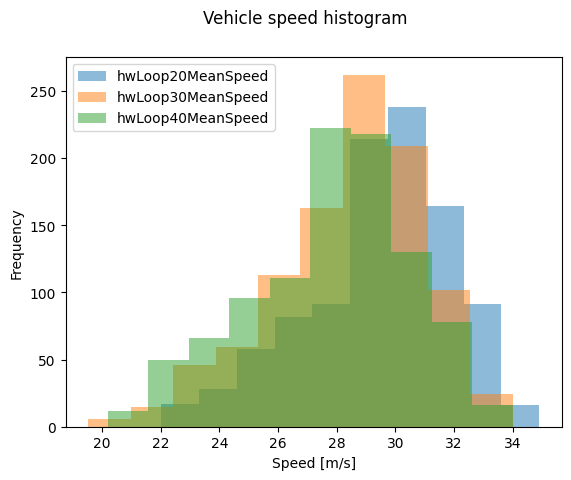

In [73]:
# Preprocess data
df = pd.read_csv("data.csv", sep=";")

# for idx, (column_name, value) in enumerate(df.iloc[0].items()):
#     print(idx, column_name, value)

# ord_df = df.iloc[:, [0,1,2,9,24,3,4,5,21,27,6,7,8,18,30,13,16,19]]
indices = [0,2,14,30,
            3,5,18,32,
            6,8,22,34,
            17,21,25]

ord_df = df.iloc[:, indices]
normalized_df = ord_df.iloc[:, :-3].copy()
fig = plt.figure()
fig.suptitle("Vehicle speed histogram")
plt.hist(df.iloc[:, [indices[-3]]], label=df.iloc[indices[-3]].keys()[indices[-3]], alpha= 0.5)
plt.hist(df.iloc[:, [indices[-2]]], label=df.iloc[indices[-2]].keys()[indices[-2]], alpha= 0.5)
plt.hist(df.iloc[:, [indices[-1]]], label=df.iloc[indices[-1]].keys()[indices[-1]], alpha= 0.5)
plt.legend()
plt.xlabel("Speed [m/s]")
plt.ylabel("Frequency")

# Normalization
for column in normalized_df.columns:
    min_val = normalized_df[column].min()
    max_val = normalized_df[column].max()
    
    if max_val - min_val != 0:
        normalized_df[column] = (normalized_df[column] - min_val) / (max_val - min_val)
    else:
        normalized_df[column] = 1

print("Stability threshold:" ,STABILITY_THRESHOLD, "km/h")
# Dataset for agents
class DatasetAgent(Dataset):
    def __init__(self, input_indices: list, label_idx: int, STABILITY_THRESHOLD) -> None:
        self.input_df = normalized_df.iloc[:, input_indices]
        self.label_df = ord_df.iloc[:, label_idx].apply(lambda x: 1 if x * 3.6 > STABILITY_THRESHOLD else 0)
        print("Stable samples:",(self.label_df == 1).sum(), ", Unstable samples:",(self.label_df == 0).sum(), "ratio:", (self.label_df == 1).sum()/((self.label_df == 0).sum()+(self.label_df == 1).sum())*100, "%")

    def __len__(self):
        return len(self.input_df)
    

    def __getitem__(self, index):
        inp = torch.Tensor(np.array(self.input_df.loc[index].values, dtype=np.float16))
        label = torch.Tensor(np.array(self.label_df.loc[index], dtype=np.float16))

        return inp, label

agent1_dataset = DatasetAgent(range(0,4), -1, STABILITY_THRESHOLD)
agent2_dataset = DatasetAgent(range(4,8), -2, STABILITY_THRESHOLD)
agent3_dataset = DatasetAgent(range(8,12), -3, STABILITY_THRESHOLD)

datasets = [agent1_dataset, agent2_dataset, agent3_dataset]
train_size = int((1-VAL_SPLIT_RATIO)*len(agent1_dataset))
val_size = int(len(agent1_dataset) - train_size)
print(f"Number of train samples each DataLoader: {train_size}, number of val samples: {val_size}")

train_loaders = []
val_loaders = []
for idx, dataset in enumerate(datasets):
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE)
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE)
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

stable = 0
unstable = 0
for val_loader in val_loaders:
    for data, labels in val_loader:
        stable += (labels == 1).sum().item()
        unstable += (labels == 0).sum().item()
print("Stable samples in ValLoader:", stable, ", unstable:", unstable, ", ratio:", stable/(stable+unstable)*100, "%")

stable = 0
unstable = 0
for train_loader in train_loaders:
    for data, labels in train_loader:
        stable += (labels == 1).sum().item()
        unstable += (labels == 0).sum().item()
print("Stable samples in TrainLoader:", stable, ", unstable:", unstable, ", ratio:", stable/(stable+unstable)*100, "%")

In [72]:
agent1_dataset.input_df.head()

,Program TL1 green,Program TL1 red,hwLoop10VehicleNum,rampLoop1VehicleNum
0,1.0,0.5,0.065041,0.412698
1,0.5,0.0,0.081301,0.444444
2,1.0,0.5,0.056911,0.428571
3,0.0,0.5,0.048780,0.539683
4,0.5,1.0,0.052846,0.539683


In [74]:
ord_df.iloc[:, -1].head()

0    30.552495
1    32.008886
2    30.758589
3    29.678282
4    28.911140
Name: hwLoop40MeanSpeed, dtype: float64

In [54]:
dataloader_iterator = iter(train_loaders[0])
for i in range(1):
    try:
        data, target = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(train_loaders[0])
        data, target = next(dataloader_iterator)

In [55]:
losssep = {0:[], 1:[], 2:[]}
accsep = {0:[], 1:[], 2:[]}

for idx, trainloader in enumerate(train_loaders):
    print(f"Agent {idx} training")
    net = StabilityClassifier()
    for epoch in range(EPOCHS):
        train(net, trainloader, 1)
        loss, accuracy = test(net, val_loaders[idx])
        print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

        losssep[idx].append(loss)
        accsep[idx].append(accuracy)

Agent 0 training
Epoch 1: validation loss 0.023154829740524293, accuracy 0.66
Epoch 2: validation loss 0.02186545044183731, accuracy 0.66
Epoch 3: validation loss 0.021060839891433716, accuracy 0.66
Epoch 4: validation loss 0.020384914577007293, accuracy 0.66
Epoch 5: validation loss 0.019585115909576414, accuracy 0.66
Epoch 6: validation loss 0.01881484866142273, accuracy 0.66
Epoch 7: validation loss 0.018132908046245576, accuracy 0.735
Epoch 8: validation loss 0.017914150208234787, accuracy 0.76
Epoch 9: validation loss 0.017521208524703978, accuracy 0.75
Epoch 10: validation loss 0.017371570616960527, accuracy 0.75
Epoch 11: validation loss 0.01710086777806282, accuracy 0.755
Epoch 12: validation loss 0.01706207975745201, accuracy 0.745
Epoch 13: validation loss 0.01703063949942589, accuracy 0.75
Epoch 14: validation loss 0.016962186992168428, accuracy 0.75
Epoch 15: validation loss 0.016744243204593657, accuracy 0.755
Epoch 16: validation loss 0.016887494325637818, accuracy 0.745


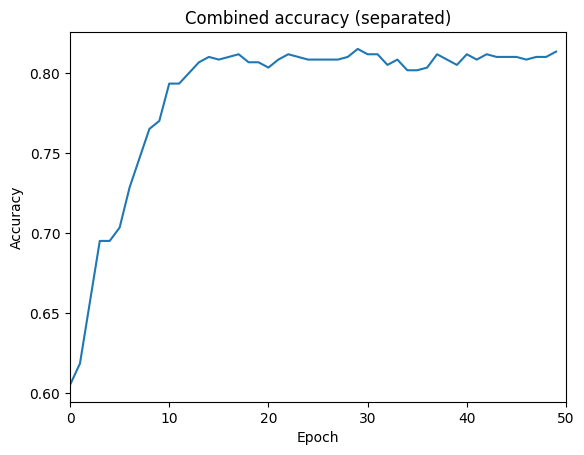

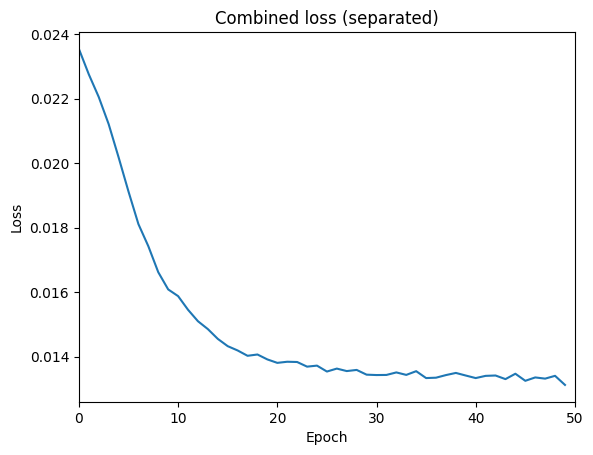

In [56]:
lossagg = []
accagg = []

for i in range(EPOCHS):
    lossagg.append(np.mean([losssep[0][i], losssep[1][i],losssep[2][i]]))
    accagg.append(np.mean([accsep[0][i], accsep[1][i],accsep[2][i]]))

plt.plot(accagg)
plt.title("Combined accuracy (separated)")
plt.xlim(0, EPOCHS)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
plt.plot(lossagg)
plt.title("Combined loss (separated)")
plt.xlim(0, EPOCHS)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [57]:
# Federated learning
def set_parameters(net, parameters: list[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> list[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [58]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = StabilityClassifier().to(DEVICE)

    # Load data
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = train_loaders[int(cid)]
    valloader = val_loaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader).to_client()

In [62]:
global_accuracies = []

def weighted_average(metrics: list[tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    for m in metrics:
        global_accuracies.append(m)

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    client_resources = {"num_cpus": 1, "num_gpus": 0.3}


# Create FedAvg strategy
strategy = fl.server.strategy.FedMedian(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=3,
    min_evaluate_clients=3,
    min_available_clients=3,
    evaluate_metrics_aggregation_fn=weighted_average,
    initial_parameters=fl.common.ndarrays_to_parameters(get_parameters(StabilityClassifier()))
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=EPOCHS),
    strategy=strategy,
    client_resources=client_resources,
)



INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-05-30 20:39:06,203	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 6468911923.0, 'memory': 12937823847.0, 'node:127.0.0.1': 1.0, 'CPU': 16.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 

0.37
0.525
0.66
0.685
0.53
0.375
0.51
0.685
0.73
0.715
0.635
0.795
0.705
0.825
0.685
0.68
0.855
0.695
0.71
0.855
0.705
0.72
0.87
0.71
0.7
0.865
0.715
0.72
0.855
0.735
0.73
0.865
0.725
0.73
0.855
0.73
0.74
0.865
0.74
0.87
0.725
0.745
0.75
0.735
0.86
0.875
0.755
0.735
0.76
0.745
0.86
0.775
0.745
0.89
0.765
0.735
0.885
0.75
0.88
0.77
0.745
0.86
0.75
0.88
0.755
0.74
0.755
0.88
0.745
0.755
0.885
0.735
0.755
0.875
0.735
0.735
0.75
0.875
0.88
0.74
0.74
0.875
0.74
0.745
0.885
0.745
0.735
0.885
0.73
0.74
0.74
0.735
0.9
0.73
0.9
0.74
0.745
0.735
0.9
0.745
0.9
0.745
0.9
0.745
0.735
0.745
0.9
0.74
0.74
0.735
0.895
0.735
0.74
0.9
0.745
0.9
0.735
0.73
0.73
0.9
0.73
0.895
0.745
0.9
0.74
0.74
0.735
0.755
0.9
0.9
0.755
0.74
0.74
0.75
0.895
0.74
0.74
0.9
0.91
0.74
0.74
0.735
0.735
0.905
0.9
0.74
0.745
0.735
0.745
0.9


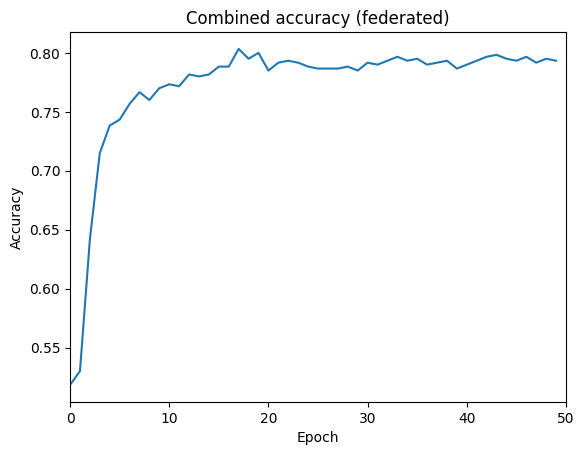

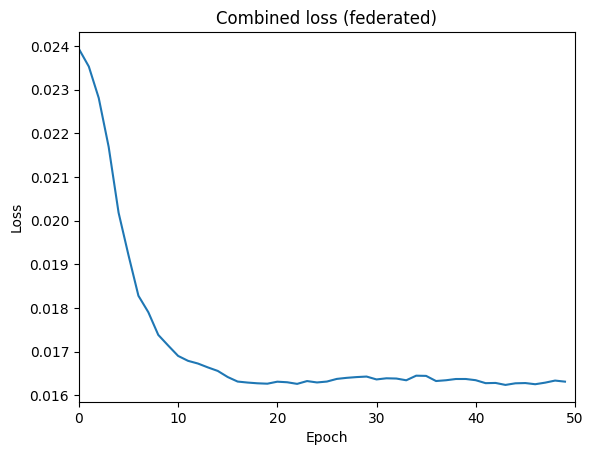

In [79]:
accs = []
for i, m in enumerate(global_accuracies):
    print(m[1]['accuracy'])
    if i % 3 == 0:
        accs.append(np.mean([global_accuracies[i][1]['accuracy'], global_accuracies[i+1][1]['accuracy'], global_accuracies[i+2][1]['accuracy']]))



plt.plot(accs)
plt.title("Combined accuracy (federated)")
plt.xlim(0, EPOCHS)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

losses = [history.losses_distributed[i][1] for i,_ in enumerate(history.losses_distributed)]

plt.plot(losses)
plt.title("Combined loss (federated)")
plt.xlim(0, EPOCHS)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()